In [38]:
import torch
import torchvision  # la liberia tiene modelos preentrenados y datasets
import os
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
import random
from fastprogress import master_bar, progress_bar
import numpy as np
from sklearn.metrics import roc_auc_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.__version__ , DEVICE

('1.7.0', 'cuda')

In [2]:
PATH = "/kaggle/input"
os.listdir(PATH)

['melanoma224', 'dataset-melanoma224']

In [3]:
#train = pd.read_csv(f'{PATH}/dataset-melanoma224/train_split.csv')
train = pd.read_csv(f'{PATH}/dataset-melanoma224/subset.csv')
val = pd.read_csv(f'{PATH}/dataset-melanoma224/val_split.csv')

train.shape, val.shape

((2220, 8), (10932, 8))

In [4]:
train["path"] = [f'{PATH}/melanoma224/jpeg224/train/{img}.jpg' for img in train["image_name"]]
val["path"] = [f'{PATH}/melanoma224/jpeg224/train/{img}.jpg' for img in val["image_name"]]

In [5]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,path
0,ISIC_0533349,IP_5208504,female,45.0,lower extremity,unknown,benign,0,/kaggle/input/melanoma224/jpeg224/train/ISIC_0...
1,ISIC_8814612,IP_0414408,male,50.0,torso,unknown,benign,0,/kaggle/input/melanoma224/jpeg224/train/ISIC_8...
2,ISIC_6515241,IP_6245507,male,45.0,lower extremity,unknown,benign,0,/kaggle/input/melanoma224/jpeg224/train/ISIC_6...
3,ISIC_5075261,IP_2117218,male,40.0,upper extremity,unknown,benign,0,/kaggle/input/melanoma224/jpeg224/train/ISIC_5...
4,ISIC_2624460,IP_1969685,male,50.0,torso,unknown,benign,0,/kaggle/input/melanoma224/jpeg224/train/ISIC_2...


In [54]:
class Dataset(torch.utils.data.Dataset): # Deberemos crear una clase datasets que heredara las propiedades de torch.utils.data.Dataset, tres funciones obligatorias, init, len, getitem
    
    def __init__(self, images, labels=None, train = True): # Constructor de esta clase, parametos que tenemos que pasarle para iniciarlo (images, labels)
        self.images = images
        self.labels = labels
        self.train = train
        
    
    def __len__(self): # Nos devolvera la longitud
        return len(self.images)
    
    def load_img(self, img):
        return io.imread(img) # leera los pixeles de la imagen
    
    def __getitem__(self,ix): # Funcions que se llamará para extraer un item de nuestro datasets
        img = self.load_img(self.images[ix])
        if self.train:
            return torch.from_numpy(img), torch.tensor([self.labels[ix]]).float() # transformamos el numpy en un tensor de pytorch y nos lo devolverá con la etiqueta
        return torch.from_numpy(img)


In [16]:
dataset = {
    "train": Dataset(train["path"], train["target"]),
    "val": Dataset(val["path"], val["target"])
}

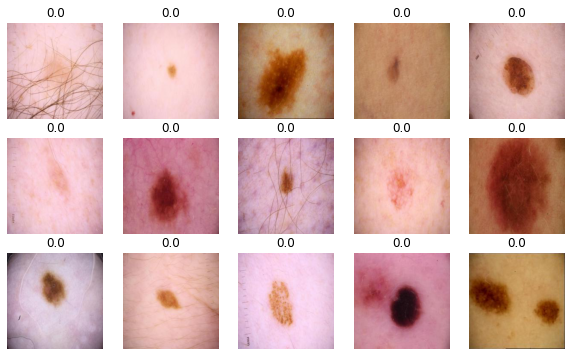

In [17]:
r, c = 3,5
fig = plt.figure(figsize=(2*c,2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r,c,_r*c+_c+1)
        ix = random.randint(0, len(dataset["train"])-1)
        img, label = dataset["train"][ix]
        plt.imshow(img)
        plt.title(label.item()) # Si ponemos item() nos devolvera el numero y no un tensor
        plt.axis(False)
plt.show()       

In [18]:
class Net(torch.nn.Module): # Crearemos nuestra clase de red neuronal y deberemos llamar a la instancia de torch.nn.Module . Minimo dos funciones, (init y forward)
    
    def __init__(self):
        super().__init__()
        self.encoder = torchvision.models.resnet50(pretrained=True) # nos devolvera una dimension de 1000 porque la resnet50 esta entrenada en 1000 clases
        #freeze
        for param in self.encoder.parameters():
            param.requires_grad = False #Cuando se aplique el algoritmo de backpropagation no aplicara los gradientes, no entrenará las primeras capas
        self.encoder.fc = torch.nn.Linear(2048, 1) # Hemos cambiado la ultima capa de resnet50 que es fc de unas dimensiones de (2048,1000) a (2048,1)
    
    def forward(self, x): # Funcion encargada de aplicar todas las capas
        B, H, W, C = x.shape # Sacamos todas las dimensiones de nuestro tensor
        x = (x/255.).float().view(B,C,H,W) # La funcion view nos permite cambiar el orden de las dimensiones de nuestro tensor
        x = self.encoder(x)
        return x
        
        
    

In [19]:
# Ejemplo de que random 
model = Net() # Instanciamos la red neuronal

BATCH_SIZE = 64
# model le pasaremos un batch de imagenes 
output = model(torch.randn(BATCH_SIZE, 224,224,3)) # le pasamos un tensor aleatorio para probar su funcionamiento y ver que nos devuelve lo mismo 
output.shape

# la dimension de los canales (nuestro caso 3) tiene que ir la segunda

torch.Size([64, 1])

In [20]:
BATCH_SIZE = 64

dataloader = { # El objeto DataLoader nos permite iterar por todo el dataset y cargar los datos en el model en batches
    "train": torch.utils.data.DataLoader(dataset['train'], batch_size = BATCH_SIZE, shuffle=True),
    "val": torch.utils.data.DataLoader(dataset['val'], batch_size = BATCH_SIZE)
}

In [47]:
# Definimos nuestro funcion para evaluar nuestro modelo
def AUC(outputs, labels):
    outputs = torch.sigmoid(outputs)
    outputs = outputs.numpy() # Pasamos de tensores a numpy por que la función roc_auc_score trabaja 
    labels = labels.numpy()
    auc = roc_auc_score(labels, outputs)
    return auc

In [61]:
# INSTANCIAMOS NUESTRO MODELO Y LO ENTRENAMOS

net = Net() # Instanciamos la red neuronal
net.to(DEVICE) # Enviamos nuestra red neuronal a la gpu

optimizer = torch.optim.Adam(net.parameters()) # Optimizador
criterion = torch.nn.BCEWithLogitsLoss() # Funcion de perdida

EPOCHS = 10
validation_steps = 10
mb = master_bar(range(1, EPOCHS+1)) # Para mostrar el progreso
best_auc = 0 

# LOOP 
for epoch in mb: # Para entrenar nuestro modelo deberemos pasarlo nº epochs por todo nuestro dataset o (DataLoader: datasets en batches)
    train_loss = []
    net.train()# Ponemos a la red neuronal en modo entrenamiento
    
    #TRAIN MODEL
    for batch in progress_bar(dataloader["train"], parent=mb): # realizamos un for por nuestro dataloader ademas de añadir el progress_bar para ver el progreso indicando su padre 
        imgs, labels = batch
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE) # Enviamos las imagenes y etiquetas a la gpu
        outputs = net(imgs) # Le pasamos nuestras imagenes a la red neuronal
        optimizer.zero_grad()# Pondrá a cero los gradientes, Si no lo ponemos ira acumulando los gradientes cada llamada a backward
        loss = criterion(outputs, labels) # al optimizador le pasamos los outputs y las etiquetas y nos devolvera la loss function
        loss.backward() # Backward calculara todos los gradientes de esta loss functions con respecto a los pesos de la red
        optimizer.step()# Aplicará los gradientes
        train_loss.append(loss.item())
        mb.child.comment = f' loss: {np.mean(train_loss):.5}'
        
    # VALIDACION
    val_loss = []
    net.eval() # Ponemos la red neuronal en modo evaluación 
    validation_step = 0
    val_outputs = torch.tensor([])# Iremos guardando todos los outputs y targets para la validacion de la métrica AUC
    val_targets = torch.tensor([])
    with torch.no_grad(): # No calculará gradientes
        for batch in progress_bar(dataloader["val"], parent=mb): 
            imgs, labels = batch
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE) 
            outputs = net(imgs)
            loss = criterion(outputs, labels) 
            optimizer.step()
            val_loss.append(loss.item())
            mb.child.comment = f' val_loss: {np.mean(val_loss):.5}'
            val_outputs = torch.cat([val_outputs,outputs.cpu()])
            val_targets = torch.cat([val_targets, labels.cpu()])
            validation_step += 1 
            if validation_step > validation_steps:
                break
    
    auc = AUC(val_outputs, val_targets)
    if auc > best_auc:
        best_auc = auc
        torch.save(net, "model.pth")
        print(f"Best model! {best_auc:.5}")
    mb.write(f'Epoch {epoch}/{EPOCHS}   train_loss: {np.mean(train_loss):.5}   val_loss: {np.mean(val_loss):.5}  val_auc: {auc:.5}')
        

Best model! 0.68521
Best model! 0.84167
Best model! 0.85407
Best model! 0.86775


In [53]:
test = pd.read_csv(f'{PATH}/melanoma224/test.csv')
test["path"] = [f'{PATH}/melanoma224/jpeg224/test/{img}.jpg' for img in test["image_name"]]
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,path
0,ISIC_0052060,IP_3579794,male,70.0,NaN,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...
2,ISIC_0058510,IP_7960270,female,55.0,torso,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...
3,ISIC_0073313,IP_6375035,female,50.0,torso,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,/kaggle/input/melanoma224/jpeg224/test/ISIC_00...


In [56]:
test_dataset = Dataset(test["path"], train = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 200)

In [59]:
imgs = next(iter(test_loader))
imgs.shape

torch.Size([200, 224, 224, 3])

In [62]:
model = torch.load("model.pth")
model.to(DEVICE)
preds = torch.tensor([]).to(DEVICE)
with torch.no_grad():
        for imgs in progress_bar(test_loader): 
            imgs = imgs.to(DEVICE)
            outputs = net(imgs)
            outputs = torch.sigmoid(outputs)
            preds = torch.cat([preds, outputs.view(-1)]) # view nos permitiria estirar todos los datos

In [63]:
preds

tensor([2.1442e-04, 3.7529e-05, 4.0792e-04,  ..., 6.7371e-04, 2.7788e-04,
        1.1284e-02], device='cuda:0')

In [64]:
submission = pd.DataFrame({'image_name':test["image_name"].values,"target":preds.cpu().numpy()})
submission

,image_name,target
0,ISIC_0052060,0.000214
1,ISIC_0052349,0.000038
2,ISIC_0058510,0.000408
3,ISIC_0073313,0.000345
4,ISIC_0073502,0.014537
...,...,...
10977,ISIC_9992485,0.002262
10978,ISIC_9996992,0.000686
10979,ISIC_9997917,0.000674
10980,ISIC_9998234,0.000278


In [65]:
submission.to_csv("submission.csv", index=False)